### Quantum Error Mitigation experiment

### reference:https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.131.210602

In [54]:
from qiskit import QuantumCircuit, QuantumRegister, Aer, transpile, assemble
from qiskit.visualization import array_to_latex

In [55]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p):

    error_meas = pauli_error([('X',p), ('I', 1 - p)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
        
    return noise_model

In [56]:
noise_model = get_noise(0.01)

In [57]:
aer_sim = Aer.get_backend('aer_simulator')
for state in ['00','01','10','11']:
    qc = QuantumCircuit(2,2)
    if state[0]=='1':
        qc.x(1)
    if state[1]=='1':
        qc.x(0)  
    qc.measure([0, 1], [0, 1])
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc)
    counts = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result().get_counts()
    print(state+' becomes', counts)

00 becomes {'00': 9788, '10': 97, '01': 115}
01 becomes {'01': 9783, '11': 117, '00': 100}
10 becomes {'10': 9817, '00': 81, '11': 101, '01': 1}
11 becomes {'11': 9786, '10': 106, '01': 103, '00': 5}


In [58]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)  
qc.measure([0, 1], [0, 1])
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc)
counts = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result().get_counts()
print(counts)

{'11': 4942, '00': 4866, '01': 101, '10': 91}


In [59]:
import numpy as np

M = [[0.9808,0.0107,0.0095,0.0001],
    [0.0095,0.9788,0.0001,0.0107],
    [0.0096,0.0002,0.9814,0.0087],
    [0.0001,0.0103,0.0090,0.9805]]

Cideal = [[5000],
          [0],
          [0],
          [5000]]

Cnoisy = np.dot(M, Cideal)
array_to_latex(Cnoisy, prefix="\\text{C}_\\text{noisy} = ")

<IPython.core.display.Latex object>

In [60]:
import scipy.linalg as la

M = [[0.9808,0.0107,0.0095,0.0001],
    [0.0095,0.9788,0.0001,0.0107],
    [0.0096,0.0002,0.9814,0.0087],
    [0.0001,0.0103,0.0090,0.9805]]

Minv = la.inv(M)

array_to_latex(Minv)

<IPython.core.display.Latex object>

In [61]:
Cmitigated = np.dot(Minv, Cnoisy)
array_to_latex(Cmitigated, prefix="\\text{C}_\\text{mitigated}=")

<IPython.core.display.Latex object>

In [62]:
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [63]:
# Import Qiskit classes
import qiskit
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit.providers.aer import noise # import AER noise model

# Measurement error mitigation functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,
                                                 CompleteMeasFitter, 
                                                 MeasurementFilter)

In [64]:
qr = QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [65]:
for circuit in meas_calibs:
    print('Circuit',circuit.name)
    print(circuit)
    print()

Circuit mcalcal_00
        ░ ┌─┐   
q59_0: ─░─┤M├───
        ░ └╥┘┌─┐
q59_1: ─░──╫─┤M├
        ░  ║ └╥┘
 c4: 2/════╩══╩═
           0  1 

Circuit mcalcal_01
       ┌───┐ ░ ┌─┐   
q59_0: ┤ X ├─░─┤M├───
       └───┘ ░ └╥┘┌─┐
q59_1: ──────░──╫─┤M├
             ░  ║ └╥┘
 c4: 2/═════════╩══╩═
                0  1 

Circuit mcalcal_10
             ░ ┌─┐   
q59_0: ──────░─┤M├───
       ┌───┐ ░ └╥┘┌─┐
q59_1: ┤ X ├─░──╫─┤M├
       └───┘ ░  ║ └╥┘
 c4: 2/═════════╩══╩═
                0  1 

Circuit mcalcal_11
       ┌───┐ ░ ┌─┐   
q59_0: ┤ X ├─░─┤M├───
       ├───┤ ░ └╥┘┌─┐
q59_1: ┤ X ├─░──╫─┤M├
       └───┘ ░  ║ └╥┘
 c4: 2/═════════╩══╩═
                0  1 



In [66]:
# Execute the calibration circuits without noise
backend = qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(meas_calibs, backend=backend, shots=1000)
cal_results = job.result()

In [67]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [68]:
noise_model = get_noise(0.1)

In [69]:
t_qc = transpile(meas_calibs, aer_sim)
qobj = assemble(t_qc, shots=10000)
cal_results = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [70]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)  
qc.measure([0, 1], [0, 1])

t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots=10000)
results = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result()
noisy_counts = results.get_counts()
print(noisy_counts)

{'10': 876, '00': 4042, '01': 888, '11': 4194}


In [71]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts()

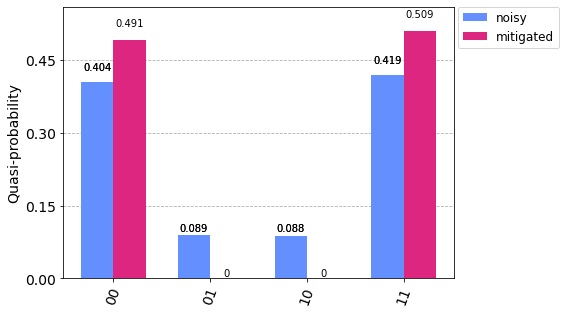

In [72]:
from qiskit.visualization import plot_histogram 
noisy_counts = results.get_counts()
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

In [73]:
import qiskit.tools.jupyter
%qiskit_version_table